In [1]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import os
import shutil
import re
import pickle as pkl
from multiprocessing import Pool
import seaborn as sns
import itertools

In [143]:
def scaling_factor(n):
    a = 0
    if n == 20000:
        return 10.48067821722932
    for i in range(1,n):
        a += 1/i
    return a

def get_a2(n):
    a = 0
    if n == 20000:
        return 1.6448840655982087
    elif n == 20001:
        return 1.6448840680982086
    for i in range(1,n):
        a += 1/(i**2)
    return a

def get_TajimasD(mut_df, Ne):
    n = 2*Ne
    a1 = scaling_factor(n)
    a2 = get_a2(n)
    b1 = (n+1)/(3*(n-1))
    b2 = 2*(n**2+n+3)/(9*n*(n-1))
    c1 = b1-1/a1
    c2 = b2-(n+2)/(a1*n)+a2/(a1**2)
    e1 = c1/a1
    e2 = c2/(a1**2+a2)
    AF = mut_df['AF']/(2*Ne)
    Tpi = 2*AF*(1-AF)
    Tpi_sum = np.sum(Tpi)
    S = len(mut_df)
    TW = S/scaling_factor(2*Ne)
    D = (Tpi_sum - TW)/np.sqrt(e1*S+e2*S*(S-1))
    return D

def get_FuLisD(mut_df, Ne):
    n = 2*Ne
    S = len(mut_df)
    Se = (mut_df['AF'] == 1).sum()
    an = scaling_factor(n)
    bn = get_a2(n)
    cn = 2*(n*an-2*(n-1))/(n-1)/(n-2)
    vd = 1+an**2/(bn+an**2)*(cn-(n+1)/(n-1))
    ud = an - 1 - vd
    D = (S - an*Se)/np.sqrt(ud*S+vd*S**2)
    return D

def get_FayWusH(mut_df,Ne):
    n = 2*Ne
    TL = mut_df['AF'].sum()/(n-1)
    AF = mut_df['AF']/n
    Tpi = 2*AF*(1-AF)
    Tpi_sum = np.sum(Tpi)
    S = len(mut_df)
    an = scaling_factor(n)
    bn = get_a2(n)
    bn_1 = get_a2(n+1)
    T = S/an
    T2 = S*(S-1)/(an**2+bn)
    var = T*(n-2)/(6*(n-1)) + T2*(18*n**2*(3*n+2)*bn_1-(88*n**3+9*n**2-13*n+6))/(9*n*(n-1)**2)
    H = (Tpi_sum - TL)/np.sqrt(var)
    return H

def get_ZengsE(mut_df,Ne):
    n = 2*Ne
    an = scaling_factor(n)
    bn = get_a2(n)
    S = len(mut_df)
    TL = mut_df['AF'].sum()/(2*Ne-1)
    TW = S/an
    T2 = S*(S-1)/(an**2+bn)
    var = TW*(n/(2*(n-1))-1/an) + T2*(bn/an**2+2*bn*(n/(n-1))**2-2*(n*bn-n+1)/(an*(n-1))-(3*n+1)/(n-1))
    E = (TL - TW)/np.sqrt(var)
    return E

In [144]:
mut_df = pd.read_table('/home/siliang/Public/backup/SLiM/Simulation_selsweep/rep30/Pseudo_20samples/Pseudo_100000.txt',header=None,delim_whitespace=True)
mut_df = mut_df.rename(columns={4:'ID',6:'pos',7:'s',10:'SG',11:'AF'})

In [145]:
get_TajimasD(mut_df, Ne)
get_FuLisD(mut_df, Ne)
get_FayWu_H(mut_df, Ne)
get_ZengsE(mut_df, Ne)

-0.042308563457137925

In [155]:
sliding_size = 1000
window_size = 10000
Ne = 10000

TajimasD_dict = {}
FuLisD_dict = {}
FayWusH_dict = {}
ZengsE_dict = {}

for version in ['Pseudo','Neutral','quasi','quasi_env20','Adaptive']:
    print(version)
    TajimasD_list = []
    FuLisD_list = []
    FayWusH_list = []
    ZengsE_list = []
    for rep in range(1,31):
        print(rep, end='\r', flush=True)
        target_dir = \
            f'/home/siliang/Public/backup/SLiM/Simulation_selsweep/rep{rep}/{version}_20samples/'   
        for N_gen in range(80000,100001,1000):
            print(N_gen,end='\r',flush=True)
            mut_df = pd.read_table(target_dir+f'{version}_{N_gen}.txt',header=None,delim_whitespace=True)
            mut_df = mut_df.rename(columns={4:'ID',6:'pos',7:'s',10:'SG',11:'AF'})
            
            for i in range(int((100000-window_size)/sliding_size)+1):
                #print(i*sliding_size)
                mut_df_sub = mut_df[
                    (i*sliding_size<mut_df['pos']) & (mut_df['pos'] < i*sliding_size+window_size)
                ]
                #Het, Theta = get_two_theta(mut_df_sub,Ne,Nsites=window_size)
                TajimasD = get_TajimasD(mut_df_sub,Ne)
                FuLisD = get_FuLisD(mut_df_sub,Ne)
                FayWusH = get_FayWusH(mut_df_sub,Ne)
                ZengsE = get_ZengsE(mut_df_sub,Ne)
                TajimasD_list.append(TajimasD)
                FuLisD_list.append(FuLisD)
                FayWusH_list.append(FayWusH)
                ZengsE_list.append(ZengsE)
                
    TajimasD_dict[version] = TajimasD_list
    FuLisD_dict[version] = FuLisD_list
    FayWusH_dict[version] = FayWusH_list
    ZengsE_dict[version] = ZengsE_list


Pseudo
Neutral
quasi0
quasi_env20
Adaptive


In [156]:
with open('TajimasD_dict.pkl','wb') as f:
    pkl.dump(TajimasD_dict,f)
with open('FuLisD_dict.pkl','wb') as f:
    pkl.dump(FuLisD_dict,f)
with open('FayWusH_dict.pkl','wb') as f:
    pkl.dump(FayWusH_dict,f)
with open('ZengsE_dict.pkl','wb') as f:
    pkl.dump(ZengsE_dict,f)

In [209]:
with open('TajimasD_dict.pkl','rb') as f:
    TajimasD_dict = pkl.load(f)
with open('FuLisD_dict.pkl','rb') as f:
    FuLisD_dict = pkl.load(f)
with open('FayWusH_dict.pkl','rb') as f:
    FayWusH_dict = pkl.load(f)
with open('ZengsE_dict.pkl','rb') as f:
    ZengsE_dict = pkl.load(f)
with open('H12_dict.pkl','rb') as f:
    H12_dict = pkl.load(f)

In [213]:
for version in version_list:
    H12_dict[version] = list(np.concatenate(H12_dict[version]))

In [189]:
rcParams_dict = {
    'font.size': 13,
    'pdf.fonttype':42,
    'font.family':'Arial',
}
mpl.rcParams.update(rcParams_dict)

In [214]:
def stat_comparism(xmin,xmax,y,P,ax): 
    ymin,ymax = ax.get_ylim()
    height = (ymax-ymin)/50
    ax.plot([xmin,xmax],[y,y],'k')
    ax.plot([xmin,xmin],[y-height,y],'k')
    ax.plot([xmax,xmax],[y-height,y],'k')
    
    if P < 0.0005:
        sig_txt = '***'
    elif P < 0.005:
        sig_txt = '**'
    elif P < 0.05:
        sig_txt = '*'
    else:
        sig_txt = 'ns'
    ax.text((xmin+xmax)/2,y,sig_txt, va='bottom',ha='center')
    
def four_stat_comparism(ax,P_list):
    assert len(P_list) == 4
    ymin,ymax = ax.get_ylim()
    y_basal = (3*ymax+1*ymin)/4
    y_space = (ymax-ymin)/11
    stat_comparism(1,2,y_basal,P_list[0],ax)
    stat_comparism(1,3,y_basal+y_space,P_list[1],ax)
    stat_comparism(2,4,y_basal+2*y_space,P_list[2],ax)
    stat_comparism(3,4,y_basal,P_list[3],ax)
    
def get_P_list(S_dict):
    t,P1 = stats.ttest_ind(S_dict['Neutral'],S_dict['quasi'])
    t,P2 = stats.ttest_ind(S_dict['Neutral'],S_dict['quasi_env20'])
    t,P3 = stats.ttest_ind(S_dict['quasi'],S_dict['Adaptive'])
    t,P4 = stats.ttest_ind(S_dict['quasi_env20'],S_dict['Adaptive'])
    return [P1,P2,P3,P4]

In [221]:
version_list = ['Pseudo','Neutral','quasi','quasi_env20','Adaptive']
label_dict = {
    'Pseudo':'$\mathit{Pseudo}$',
    'Neutral':'$\mathit{Neutral}$',
    'quasi':'$\mathit{QuasiNeu}$ (inf env)',
    'quasi_env20':'$\mathit{QuasiNeu}$ (20 env)',
    'Adaptive':'$\mathit{Adaptive}$'
}

ylabel_list = ["Tajima's $\mathit{D}$", "Fu and Li's $\mathit{D}$",
               "Fay and Wu's $\mathit{H}$", "Zeng's $\mathit{E}$", "H12"]
dict_list = [TajimasD_dict, FuLisD_dict, FayWusH_dict, ZengsE_dict, H12_dict]

fig, axes = plt.subplots(3,2,figsize=[10,15],facecolor='w')

for i,ax in enumerate(axes.flatten()):
    if i == 5:
        break
    S_dict = dict_list[i]
    if i == 4:
        scale = 'width'
        ax.set_ylim(-0.02,1.3)
    else:
        scale = 'area'
    sns.violinplot(data=[S_dict[version] for version in version_list],
                   color='lightgrey',ax=ax,cut=0,scale=scale)
    ax.set_xticklabels(label_dict.values(),rotation=20,rotation_mode="anchor",ha='right')
    ax.set_ylabel(ylabel_list[i])
    P_list = get_P_list(S_dict)
    four_stat_comparism(ax,P_list)
    
plt.tight_layout()
plt.savefig('./FigS10.pdf')

In [30]:
### non-normalized statistics:

# def get_a2(n):
#     a = 0
#     for i in range(1,n):
#         a += 1/(i**2)
#     return a

# def get_two_theta(mut_df,Ne,Nsites):
#     H_list = []
#     for i,row in mut_df.iterrows():
#         AF = row['AF']/(2*Ne)
#         H = 2*AF*(1-AF) # expected heterozygosity
#         H_list.append(H)
#     H_list = H_list + [0]*(Nsites-len(mut_df))
#     H_mean = np.mean(H_list) # genetic diversity
#     Theta = len(mut_df)/scaling_factor(2*Ne)/Nsites# theta inferred from number of segregating sites
#     return H_mean, Theta

# def get_TajimasD(H, Theta, n, S, Nsites):
#     a1 = scaling_factor(n)
#     a2 = get_a2(n)
#     b1 = (n+1)/(3*(n-1))
#     b2 = 2*(n**2+n+3)/(9*n*(n-1))
#     c1 = b1-1/a1
#     c2 = b2-(n+2)/(a1*n)+a2/(a1**2)
#     e1 = c1/a1
#     e2 = c2/(a1**2+a2)
#     D = (H - Theta)*Nsites/np.sqrt(e1*S+e2*S*(S-1))
#     return D

# def get_FuLisD(mut_df, Ne):
#     Se = (mut_df['AF'] == 1).sum()
#     S = len(mut_df['AF'])
#     an = scaling_factor(2*Ne)
#     D = Si/(an-1) - Se
#     D = (S - an*Se)/np.sqrt()
#     return D

# def get_FayWusH(mut_df,Ne):
#     H1_list = []
#     H2_list = []
#     AF = mut_df['AF']/(2*Ne)
#     Tpi = 2*AF*(1-AF)
#     Tpi_sum = np.sum(Tpi)
#     TH = 2*AF*AF
#     TH_sum = np.sum(TH)
#     H = Tpi_sum - TH_sum
#     return H

# def get_ZengsE(mut_df,Ne):
#     TL = mut_df['AF'].sum()/(2*Ne-1)
#     S = len(mut_df)
#     TW = S/scaling_factor(2*Ne)
#     E = TL - TW
#     return E

# H,Theta = get_two_theta(mut_df, Ne, 160000)
# get_TajimasD(H, Theta, n=10000, S=len(mut_df), Nsites=160000)

In [4]:
def worker(target_dir):
    for N_gen in range(181000,200001,1000):
            mut_df = pd.read_table(target_dir+f'{version}_{N_gen}.txt',header=None,delim_whitespace=True)
            mut_df = mut_df.rename(columns={4:'ID',6:'pos',7:'s',10:'SG',11:'AF'})
            Het, Theta = get_two_theta(mut_df,Ne,Nsites=160000)
            D = get_TajimasD(Het, Theta,2*Ne,len(mut_df),Nsites=160000)
            D_list.append(D)
            H = get_FayWu_H(mut_df,Ne)
            H_list.append(H)

In [29]:
def worker(target_dir, version, Ne, N_gen):
    mut_df = pd.read_table(target_dir+f'{version}_{N_gen}.txt',header=None,delim_whitespace=True)
    mut_df = mut_df.rename(columns={4:'ID',6:'pos',7:'s',10:'SG',11:'AF'})
    Het, Theta = get_two_theta(mut_df,Ne,Nsites=160000)
    D = get_TajimasD(Het, Theta,2*Ne,len(mut_df),Nsites=160000)
    #D_list.append(D)
    H = get_FayWu_H(mut_df,Ne)
    #H_list.append(H)
    return D,H

p = Pool(processes=20)
rep=1
version='Neutral'
Ne=10000
target_dir = f'./SLiM/Simulation_log/rep{rep}/{version}_20samples/'
data = p.starmap(worker, [(target_dir, version, Ne, i) for i in [181000,182000,183000]])
p.close()
print(data)

[(-1.882423569978271, 24.333834679999995), (-1.900193611443189, 24.316067600000025), (-1.899139725158992, 24.746683989999966)]


In [39]:
p.close()

In [43]:
version_list = ['Pseudo','Neutral','Adaptive','quasi_pop10000','quasi_env20']
Ne = 10000
D_dict = {}
H_dict = {}
p = Pool(processes=20)
for version in version_list:
    print(version)
    D_list = []
    H_list = []
    Theta_list = []
    for rep in range(1,31):
        target_dir = f'./SLiM/Simulation_log/rep{rep}/{version}_20samples/'
        print(rep,end='\r',flush=True)
        data = p.starmap(worker, [(target_dir, version, Ne, i) for i in range(181000,200001,1000)])
        D_list_sub, H_list_sub = np.array(data).T
        D_list += list(D_list_sub)
        H_list += list(H_list_sub)
    D_dict[version] = D_list
    H_dict[version] = H_list
p.close()

Pseudo
Neutral
Adaptive
quasi_pop10000
quasi_env20


In [87]:
rcParams_dict = {
    'xtick.bottom': True,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

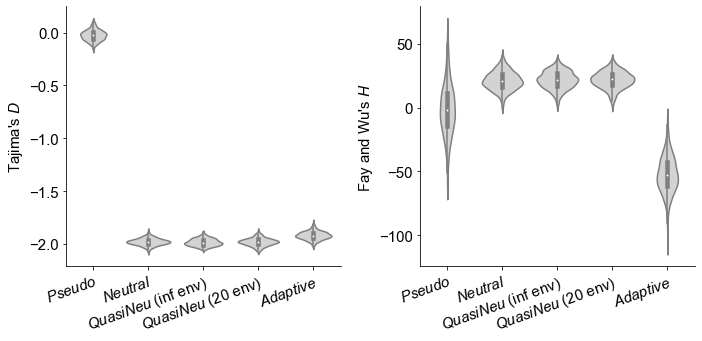

In [137]:
version_list = ['Pseudo','Neutral','quasi_pop10000','quasi_env20','Adaptive']
label_dict = {
    'Pseudo':'$\mathit{Pseudo}$',
    'Neutral':'$\mathit{Neutral}$',
    'quasi_pop10000':'$\mathit{QuasiNeu}$ (inf env)',
    'quasi_env20':'$\mathit{QuasiNeu}$ (20 env)',
    'Adaptive':'$\mathit{Adaptive}$'
}

fig, axes = plt.subplots(1,2,figsize=[10,5],facecolor='w')
sns.violinplot(data=[D_dict[version] for version in version_list],color='lightgrey',ax=axes[0])
axes[0].set_xticklabels(label_dict.values(),rotation=20,rotation_mode="anchor",ha='right')
axes[0].set_ylabel("Tajima's $\mathit{D}$")
sns.violinplot(data=[H_dict[version] for version in version_list],color='lightgrey',ax=axes[1])
axes[1].set_xticklabels(label_dict.values(),rotation=20,rotation_mode="anchor",ha='right')
axes[1].set_ylabel("Fay and Wu's $\mathit{H}$")
plt.tight_layout()
plt.savefig('./Figures/FigS2.pdf')

In [134]:
for M1,M2 in itertools.combinations(version_list,2):
    _,P = stats.ttest_ind(D_dict[M1],D_dict[M2])
    print(M1,M2,P)

Pseudo Neutral 0.0
Pseudo quasi_pop10000 0.0
Pseudo quasi_env20 0.0
Pseudo Adaptive 0.0
Neutral quasi_pop10000 0.024232722851714985
Neutral quasi_env20 0.7911235155385159
Neutral Adaptive 1.0967319702403718e-138
quasi_pop10000 quasi_env20 0.0594345987647827
quasi_pop10000 Adaptive 5.568977890616726e-153
quasi_env20 Adaptive 7.160203133168218e-132


In [136]:
for M1,M2 in itertools.combinations(version_list,2):
    _,P = stats.ttest_ind(H_dict[M1],H_dict[M2])
    print(M1,M2,P)

Pseudo Neutral 4.8245841711857045e-115
Pseudo quasi_pop10000 6.045256004944239e-121
Pseudo quasi_env20 5.560661846515971e-122
Pseudo Adaptive 7.00164502118534e-298
Neutral quasi_pop10000 0.14594324485577448
Neutral quasi_env20 0.10743834585680417
Neutral Adaptive 0.0
quasi_pop10000 quasi_env20 0.8895864495965506
quasi_pop10000 Adaptive 0.0
quasi_env20 Adaptive 0.0


In [127]:
itertoo version_list

In [129]:
a = axes[0]
a.

<AxesSubplot:ylabel="Tajima's $\\mathit{D}$">

In [79]:
stats.ttest_1samp(D_dict['Pseudo'],0)

Ttest_1sampResult(statistic=-4.016819092148981, pvalue=0.00038219598606416933)

In [19]:
stats.ttest_ind(D_dict['quasi_pop10000'],D_dict['Neutral'])

Ttest_indResult(statistic=0.4132618474408302, pvalue=0.6809387368594668)

In [11]:
version_list = ['Pseudo','Neutral','Adaptive','quasi_pop10000']
Ne = 10000
H_dict = {}
for version in version_list:
    H_list = []
    print(version)
    for rep in range(1,31):
        target_dir = f'./SLiM/Simulation_log/rep{rep}/{version}_20samples/'
        mut_df = pd.read_table(target_dir+f'{version}_200000.txt',header=None,delim_whitespace=True)
        mut_df = mut_df.rename(columns={4:'ID',6:'pos',7:'s',10:'SG',11:'AF'})
        H = get_FayWu_H(mut_df,Ne)
        H_list.append(H)
    H_dict[version] = H_list

Pseudo


KeyboardInterrupt: 

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/siliang/usr/anaconda3/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/siliang/usr/anaconda3/lib/python3.8/multiprocessing/pool.py", line 692, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/siliang/usr/anaconda3/lib/python3.8/multiprocessing/pool.py", line 672, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 


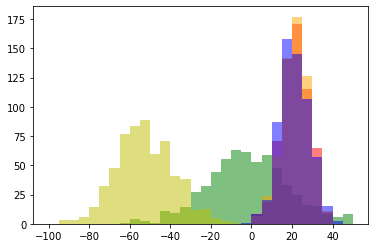

In [46]:
plt.hist(H_dict['Pseudo'],bins=30,alpha=0.5,color='g',range=[-100,50])
plt.hist(H_dict['quasi_pop10000'],bins=30,alpha=0.5,color='r',range=[-100,50])
plt.hist(H_dict['quasi_env20'],bins=30,alpha=0.5,color='orange',range=[-100,50])
plt.hist(H_dict['Neutral'],bins=30,alpha=0.5,color='b',range=[-100,50])
plt.hist(H_dict['Adaptive'],bins=30,alpha=0.5,color='y',range=[-100,50])
plt.show()

In [125]:
stats.ttest_ind(H_dict['quasi_pop10000'],H_dict['Neutral'])

Ttest_indResult(statistic=-0.3335583503194933, pvalue=0.7399157770424893)

In [9]:
version = 'Neutral' #'quasi_pop10000'
target_dir = f'./SLiM/Simulation_log/rep1/{version}_20samples/'
mut_df = pd.read_table(target_dir+f'{version}_200000.txt',header=None,delim_whitespace=True)
mut_df = mut_df.rename(columns={4:'ID',6:'pos',7:'s',10:'SG',11:'AF'})

In [15]:
sliding_size = 500
window_size = 4000
Ne = 10000

D_dict = {}
H_dict = {}

for version in ['Pseudo','Neutral','quasi','quasi_env','Adaptive']:
    print(version)
    target_dir = f'./SLiM/Simulation_selsweep/rep1/{version}_20samples/'
    H_list_list = []
    D_list_list = []
    for N_gen in range(80000,100001,1000):
        print(N_gen,end='\r',flush=True)
        mut_df = pd.read_table(target_dir+f'{version}_{N_gen}.txt',header=None,delim_whitespace=True)
        mut_df = mut_df.rename(columns={4:'ID',6:'pos',7:'s',10:'SG',11:'AF'})
        H_list = []
        D_list = []
        for i in range(int((100000-window_size)/sliding_size)+1):
            #print(i*sliding_size)
            mut_df_sub = mut_df[
                (i*sliding_size<mut_df['pos']) & (mut_df['pos'] < i*sliding_size+window_size)
            ]
            Het, Theta = get_two_theta(mut_df_sub,Ne,Nsites=window_size)
            D = get_TajimasD(Het, Theta,2*Ne,len(mut_df_sub),Nsites=window_size)
            H = get_FayWu_H(mut_df_sub,Ne)
            D_list.append(D)
            H_list.append(H)

        D_list_list.append(D_list)
        H_list_list.append(H_list)
        
    D_dict[version] = np.concatenate(D_list_list)
    H_dict[version] = np.concatenate(H_list_list)


In [5]:
np.concatenate([[1,2,3],[1,2,3]])

array([1, 2, 3, 1, 2, 3])

In [14]:
# H_list_list_quasi = H_list_list
# D_list_list_quasi = D_list_list

In [16]:
jpg_idx = 1
for D_list, H_list in zip(D_list_list,H_list_list):
    fig,axes = plt.subplots(2,1,figsize=[40,8],facecolor='w')
    axes[0].plot(D_list,label="Tajima's D")
    axes[1].plot(H_list,label="Fay and Wu's H")
    N_ticks = int(len(H_list)/7+1)
    for ax in axes:
        ax.set_xticks(
            [(len(H_list)-1) * (i - window_size/2)/(100000-window_size) for i in range(0,100001,5000)],
        )
        ax.set_xticklabels(range(0,100001,5000))

    axes[0].set_ylim(-2.75,-1.5)
    axes[1].set_ylim(-5,4)
    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    
    plt.savefig(f'./SLiM/code/Simulation_log/rep1/quasi_del_pop5000_20samples/TFW_figures/{jpg_idx}.jpg')
    plt.close()
    jpg_idx += 1

In [213]:
#H_list_QuasiNeu = H_list
#H_list_neutral = H_list
H_list_neutral2 = H_list

In [222]:
stats.ttest_ind(H_list_QuasiNeu,H_list_neutral2)

Ttest_indResult(statistic=-2.33766347989028, pvalue=0.01991762940876343)

In [215]:
np.mean(H_list_neutral2)

3.471035012901554

In [216]:
np.mean(H_list_neutral)

2.99674143849741

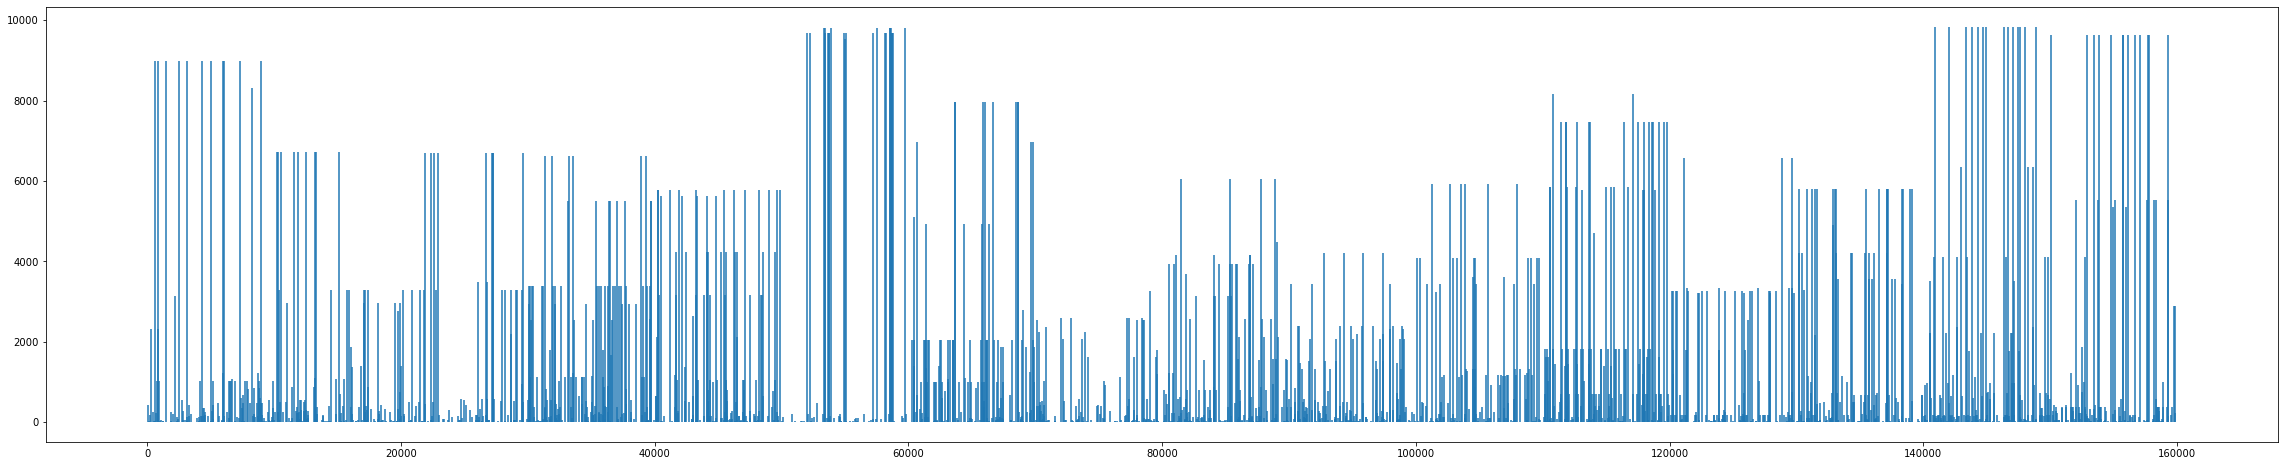

In [142]:
plt.subplots(figsize=[40,8],facecolor='w')
for i,row in mut_df.iterrows():
    pos = row['pos']
    AF = row['AF']
    plt.vlines(pos,ymin=0,ymax=AF)
plt.show()

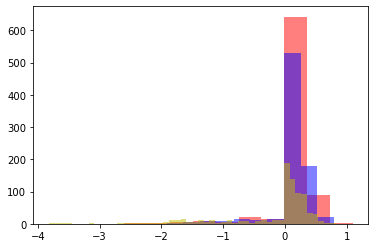

In [152]:
plt.hist(H_dict['quasi_pop10000'],bins=10,alpha=0.5,color='r')
plt.hist(H_dict['Neutral'],bins=10,alpha=0.5,color='b')
plt.hist(H_dict['Adaptive'],bins=50,alpha=0.5,color='y')
plt.show()

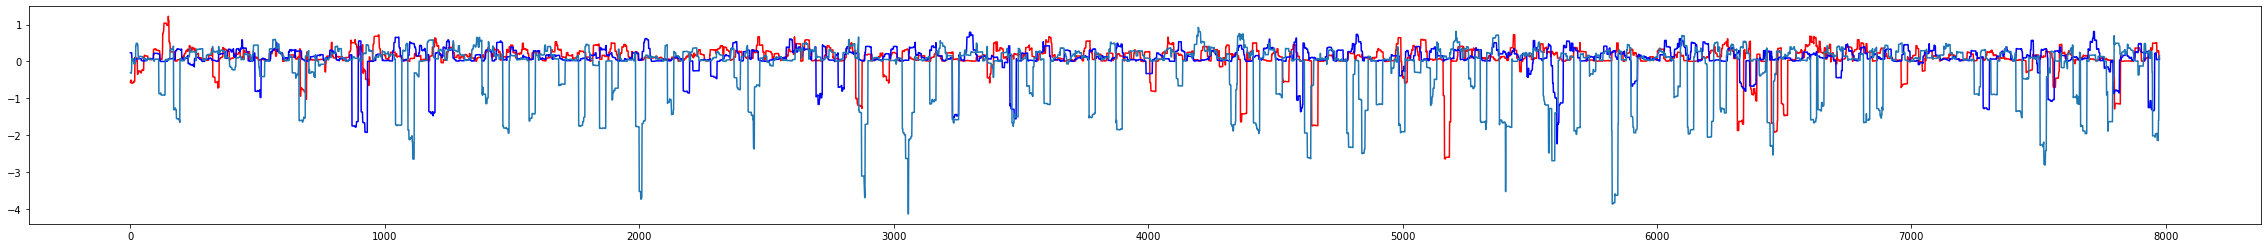

In [154]:
plt.subplots(figsize=[40,4])
plt.plot(H_dict['quasi_pop10000'],color='r')
plt.plot(H_dict['Neutral'],color='b')
plt.plot(H_dict['Adaptive'])
#plt.plot(D_dict['Pseudo'])